# Задание 1. A/B–тестирование

**1.1 Условие**

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**1.2 Входные данные**

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

Подключим игнорирование warnings:

In [297]:
import warnings
warnings.filterwarnings("ignore")

Импортируем необходимые библиотеки:

In [298]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandahouse as ph
from scipy.stats import norm
from scipy.stats import bootstrap
from scipy import stats
from scipy.stats import chi2_contingency
import pingouin as pg


%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


import requests as req
from urllib.parse import urlencode
from tqdm.auto import tqdm

Установим общие настройки графиков:

In [299]:
sns.set(font_scale=1, style="whitegrid", rc={'figure.figsize': (20, 7)})

Загрузим необходимые файлы и проведем предварительный анализ данных

In [300]:
def yandex_data(public_key):
    
    
    """
    Функция считывает csv-файлы с Яндекс-диска с помощью API, а затем загружает их в блокнот
    """
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = req.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

In [301]:
groups = pd.read_csv(yandex_data('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')
groups_add = pd.read_csv(yandex_data('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), sep=',') 
active_studs = pd.read_csv(yandex_data('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';') 
checks = pd.read_csv(yandex_data('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';')

In [302]:
print(f"В датафрейме groups {groups.shape[0]} строк и {groups.shape[1]} столбца")
print(f"В датафрейме groups_add {groups_add.shape[0]} строк и {groups_add.shape[1]} столбца")
print(f"В датафрейме active_studs {active_studs.shape[0]} строк и {active_studs.shape[1]} столбец")
print(f"В датафрейме checks {checks.shape[0]} строк и {checks.shape[1]} столбца")

В датафрейме groups 74484 строк и 2 столбца
В датафрейме groups_add 92 строк и 2 столбца
В датафрейме active_studs 8341 строк и 1 столбец
В датафрейме checks 541 строк и 2 столбца


In [303]:
print(f"В датафрейме groups {groups.duplicated().sum()} дубликатов")
print(f"В датафрейме groups_add {groups_add.duplicated().sum()} дубликатов")
print(f"В датафрейме active_studs {active_studs.duplicated().sum()} дубликатов")
print(f"В датафрейме checks {checks.duplicated().sum()} дубликатов")

В датафрейме groups 0 дубликатов
В датафрейме groups_add 0 дубликатов
В датафрейме active_studs 0 дубликатов
В датафрейме checks 0 дубликатов


Посмотрим, есть ли в каждом датафрейме пустые значения:

In [304]:
groups.isnull().sum()

id     0
grp    0
dtype: int64

In [305]:
groups_add.isnull().sum()

id     0
grp    0
dtype: int64

In [306]:
active_studs.isnull().sum()

student_id    0
dtype: int64

In [307]:
checks.isnull().sum()

student_id    0
rev           0
dtype: int64

Пустых значений нигде нет

Посмотрим на уникальное количество пользователей в каждом датафрейме:

In [308]:
groups.nunique()

id     74484
grp        2
dtype: int64

In [309]:
groups_add.nunique()

id     92
grp     2
dtype: int64

In [310]:
active_studs.nunique()

student_id    8341
dtype: int64

In [311]:
checks.nunique()

student_id    541
rev            39
dtype: int64

Проверим, действительно ли в датафрейме groups_add все данные новые:

In [312]:
groups[groups.id.isin(groups_add.id)].sum()

id     0.0
grp    0.0
dtype: float64

Объединим два датафрейма с информацией о пользователях, переименовав колонку id на student_id, чтобы была связь с двумя другими датафреймами (active_studs, checks):

In [313]:
all_users = pd.concat([groups, groups_add]).rename(columns={'id': 'student_id'})

In [314]:
all_users.shape[0]

74576

Посмотрим на количество пользователей в каждой из групп:

In [315]:
all_users.groupby('grp', as_index=False).agg({'student_id': 'count'})

,grp,student_id
0,A,14693
1,B,59883


Добавим колонку-флаг, которая будет показывать был ли пользователь активным:

In [316]:
active_studs['activity'] = 1

Объединим с остальными датафреймами:

In [317]:

users = all_users.merge(active_studs, on='student_id', how='outer').fillna(0)

In [318]:
users = users.merge(checks, on='student_id', how='outer').fillna(0)

Создадим колонку, которая будет отображать наличие оплаты:

In [319]:
users['rev_flag'] = users.rev.apply(lambda x: 1 if x > 0 else 0)

Проверим, есть ли в данных ошибки:

In [320]:
users[(users.activity == 0.0) & (users.rev > 0)]

,student_id,grp,activity,rev,rev_flag
39,3185,B,0.0,690.0,1
121,25973,B,0.0,690.0,1
125,26280,B,0.0,690.0,1
223,100645,B,0.0,630.0,1
254,102534,B,0.0,580.0,1
...,...,...,...,...,...
72452,5291900,B,0.0,199.0,1
72753,5331842,B,0.0,290.0,1
73632,5486319,B,0.0,199.0,1
74049,5562806,B,0.0,398.0,1


Таких строк - 149, это неактивные пользователи, при этом они совершили покупку, это может быть ошибкой в данных или чем-то другим, но нам нужны именно те пользователи, у которых наблюдалась активность за исследуемый промежуток времени, поэтому несмотря на наличие оплаты этих пользователей нельзя включать в основной датафрейм для анализа

Посмотрим на соотношение активности пользователей в двух группах:

In [321]:
pd.crosstab(users.grp, users.activity)

activity,0.0,1.0
grp,,
A,13155,1538
B,53080,6803


В тестовой группе гораздо больше пользователей, общее соотношение приблизительно 20/80

Построим график соотношения активности:

In [322]:
fig = px.histogram(users[['grp', 'activity']], x='grp', color='activity')
fig.show()

In [323]:
users_active = users.query('activity > 0')
users_active.head(1)

,student_id,grp,activity,rev,rev_flag
1,1627,A,1.0,990.0,1


Посмотрим на количество активных пользователей:

In [324]:
users_active.shape[0]

8341

Построим график распределения сумм покупок в двух группах:

In [325]:
users_active_rev = users_active.query('rev > 0')

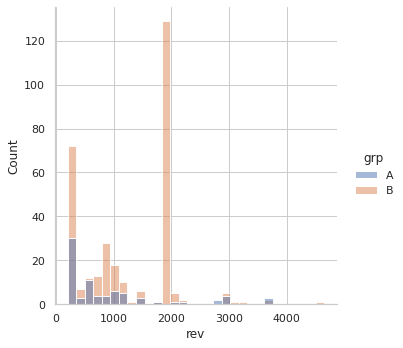

In [326]:
sns.displot(data=users_active_rev, x='rev', hue='grp', bins=30)

Посмотрим детальнее, какие суммы покупок самые популярные в двух группах

In [327]:
users_active_rev.query('grp == "A"').rev.value_counts().head(5)

290.0    25
580.0     6
990.0     5
590.0     5
199.0     5
Name: rev, dtype: int64

In [328]:
users_active_rev.query('grp == "B"').rev.value_counts().head(5)

1900.0000    93
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
Name: rev, dtype: int64

В тестовой группе топовыми являются дорогие покупки, количество покупок сравнивать сложно, потому что в тестовой группе гораздо больше пользователей.

Построим ещё один график, отображающий разницу в суммах покупок нагляднее:

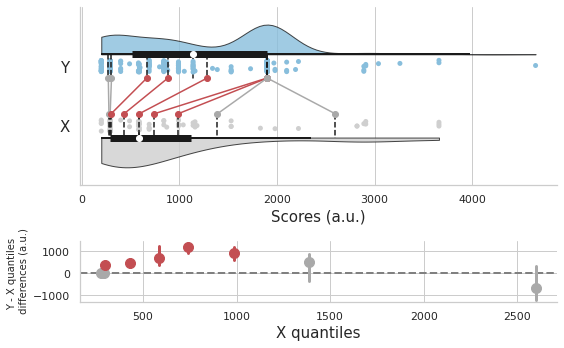

In [329]:
pg.plot_shift(users_active_rev.query("grp=='A'")["rev"],
             users_active_rev.query("grp=='B'")["rev"])
plt.show()

**1.3 Вопросы**

**Вопросы:**
 - На какие метрики Вы смотрите в ходе анализа и почему?
 - Имеются ли различия в показателях и с чем они могут быть связаны?
 - Являются ли эти различия статистически значимыми?
 - Стоит ли запускать новую механику на всех пользователей?

**Метрики, на которые мы обратим внимание:**

 - CR (конверсия в покупку)
 - ARPU (средняя выручка на активного пользователя)
 - ARPPU (средняя выручка на совершившего покупку пользователя)

# Метрика CR (конверсия в покупку)

H0: CR одинаковые в обоих группах

H1: CR разные в обоих группах

In [330]:
test_group_users = users_active.query("grp == 'B'")

In [331]:
control_group_users = users_active.query("grp == 'A'")

Посчитаем метрику для каждой из групп

In [332]:
round(test_group_users.rev_flag.sum()/test_group_users.activity.count() * 100, 1)

4.6

In [333]:
round(control_group_users.rev_flag.sum()/control_group_users.activity.count() * 100, 1)

5.1

**Конверсия в покупку в контрольной группе(A) выше, чем в тестовой(B)**

Проверим гипотезу с помощью статистического теста хи-квадрат, так как CR - дискретная и категориальная переменная, показывающая отношение пользователей, которые совершили покупку ко всем активным пользователям. Хи-квадрат используется для анализа зависимости между категориальными переменными, в том числе для оценки значимости различий между группами.

За уровень значимости для всех проводимых тестов примем а(альфа) = 0.05

In [334]:
сhi2_crosstab = pd.crosstab(users_active['grp'], users_active['rev_flag'])

In [335]:
сhi2_crosstab

rev_flag,0,1
grp,,
A,1460,78
B,6489,314


In [336]:
stat, p, _, _ = stats.chi2_contingency(сhi2_crosstab)

In [337]:
p

0.48625240457231045

Различия статистически не значимы, т.к. p-value = 0.48625240457231045

# Метрика ARPU (средняя выручка на активного пользователя)

H0: ARPU одинаковые в обоих группах

H1: ARPU разные в обоих группах

In [338]:
test_group_users_arpu = test_group_users.rev

In [339]:
control_group_users_arpu = control_group_users.rev

Рассчитаем метрику для каждой группы

In [340]:
test_group_users.query("rev > 0")['rev'].sum()/len(test_group_users)

58.05879810377775

In [341]:
control_group_users.query("rev > 0")['rev'].sum()/len(control_group_users)

47.34720416124838

**Средняя выручка на активного пользователя в покупку в тестовой группе(B) выше, чем в контрольной(A)**

Чтобы выбрать наиболее подходящий статистический тест, необходимо проверить выборки на нормальность, а также на гомоскедастичность дисперсий

Проверим обе группы на нормальность распределения

In [342]:
stats.normaltest(control_group_users_arpu)

NormaltestResult(statistic=2240.595797407402, pvalue=0.0)

In [343]:
stats.normaltest(test_group_users_arpu)

NormaltestResult(statistic=7797.399211581946, pvalue=0.0)

(array([1.49e+03, 1.80e+01, 1.00e+01, 5.00e+00, 3.00e+00, 2.00e+00,
        1.00e+00, 6.00e+00, 0.00e+00, 3.00e+00]),
 array([   0.,  366.,  732., 1098., 1464., 1830., 2196., 2562., 2928.,
        3294., 3660.]),
 <a list of 10 Patch objects>)

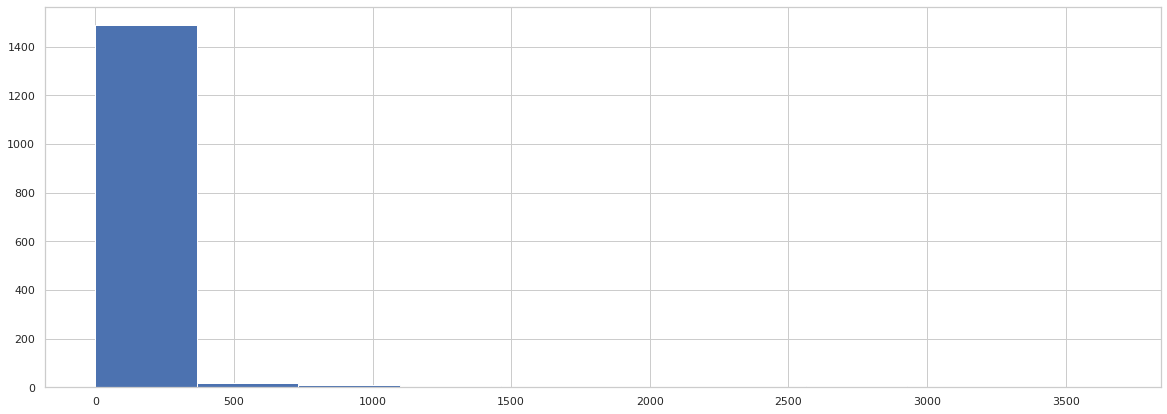

In [344]:
plt.hist(control_group_users_arpu)

(array([6.567e+03, 5.400e+01, 3.000e+01, 6.000e+00, 1.360e+02, 0.000e+00,
        6.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([   0.,  465.,  930., 1395., 1860., 2325., 2790., 3255., 3720.,
        4185., 4650.]),
 <a list of 10 Patch objects>)

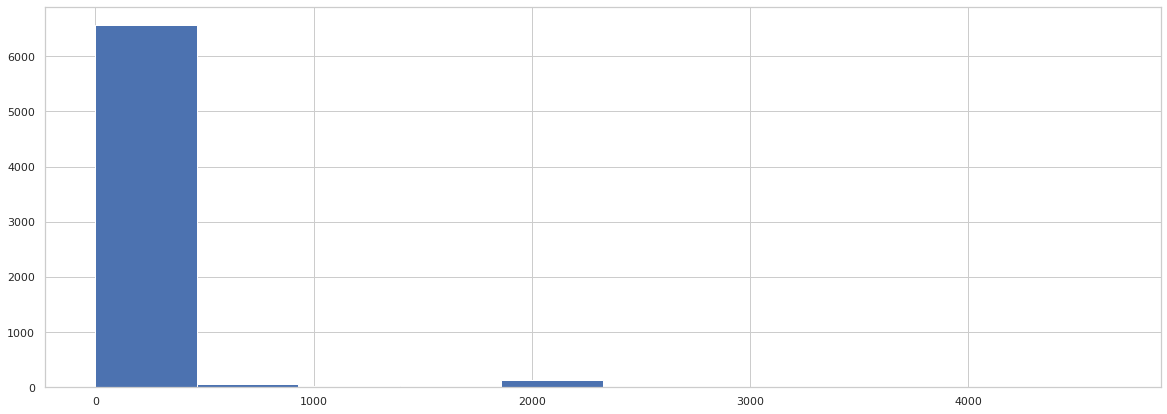

In [345]:
plt.hist(test_group_users_arpu)

В обеих группах распределения не являются нормальными, потому что p < 0.05

Проверим гомоскедастичность дисперсий с помощью теста Левена

In [346]:
stats.levene(control_group_users_arpu, test_group_users_arpu, center='median')

LeveneResult(statistic=1.501460829433639, pvalue=0.22048133327049665)

p-value > 0.05, значит дисперсии гомоскедастичны

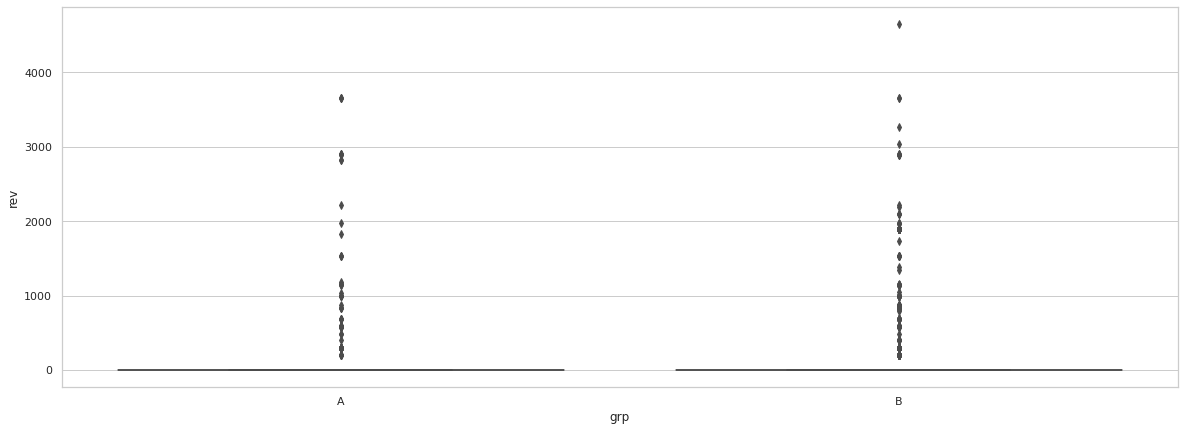

In [347]:
sns.boxplot(x= 'grp', y= 'rev', data = users_active)

По графикам видно, что в выборках есть выбросы

Неравномерность распределения и выбросы могут повлиять на среднее значение при интерпретации результатов параметрического t-теста, поэтому проверим гипотезу с помощью статистического теста bootstrap, который является весьма универсальным методом, так как он устойчив к ненормальности распределений и сглаживает выбросы в данных

In [348]:
arpu = users_active[['grp', 'rev']]

In [349]:
arpu

,grp,rev
1,A,990.0
10,B,0.0
12,B,0.0
43,A,0.0
45,B,0.0
...,...,...
74543,B,0.0
74545,B,0.0
74558,A,0.0
74561,B,0.0


In [350]:
arpu_b = arpu.query('grp == "B"')
arpu_a = arpu.query('grp == "A"')

In [351]:
stats.bootstrap((arpu_a.rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=35.126732098093925, high=64.92936045384138), standard_error=7.401407911973422)

In [352]:
stats.bootstrap((arpu_b.rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=51.02236427934581, high=65.89288093387982), standard_error=3.758196878606129)

In [353]:
mean_diff_arpu = []

for i in range(10000):
    sample_data_control = arpu_a.sample(frac=1, replace=True)
    sample_mean_control = sample_data_control.rev.mean()
    
    
    sample_data_exp = arpu_b.sample(frac=1, replace=True)
    sample_data_exp = sample_data_exp.rev.mean()
    
    sample_mean_diff_arpu = sample_data_exp - sample_mean_control
    mean_diff_arpu.append(sample_mean_diff_arpu)

In [354]:
pd.Series(mean_diff_arpu).quantile(0.975)

26.572689675831445

In [355]:
pd.Series(mean_diff_arpu).quantile(0.025)

-6.0320832478208395

По результатам bootstrap теста разница среднего (доверительный интервал) находится в диапазоне от -7 до 26, включает ноль, а это значит разница средних не является стат значимой, поэтому мы не можем отклонить Н0 - ARPU в группах статистически значимо не различается

Построим график, чтобы увидеть как выглядит распределение разницы средних

In [356]:
data_arpu  = pd.DataFrame(mean_diff_arpu)

In [357]:
l = (1 - 0.95)/2
r = 1 - (1 - 0.95)

In [358]:
quantiles = data_arpu.quantile([l, r])

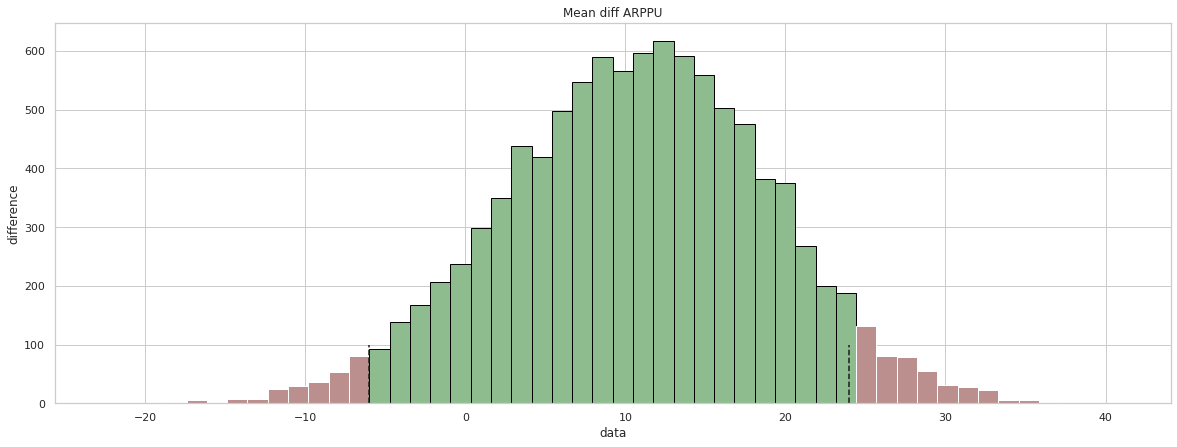

In [359]:
_, _, bars = plt.hist(data_arpu[0], bins=50)
for bar in bars:
        if bar.get_x() <= quantiles.iloc[0][0] or bar.get_x() >= quantiles.iloc[1][0]:
            bar.set_facecolor('rosybrown')
        else: 
            bar.set_facecolor('darkseagreen')
            bar.set_edgecolor('black')
    
plt.style.use('seaborn-pastel')
plt.vlines(quantiles, ymin=0, ymax=100, linestyle='--')
plt.xlabel('data')
plt.ylabel('difference')
plt.title("Mean diff ARPPU")
plt.show()

# ARPPU (средняя выручка на совершившего покупку пользователя)

H0: ARPPU одинаковые в обоих группах

H1: ARPPU разные в обоих группах

Рассчитаем метрику для обеих групп

In [360]:
test_group_users.query("rev > 0")['rev'].sum()/len(test_group_users.query('rev != 0'))

1257.8789920382164

In [361]:
control_group_users.query("rev > 0")['rev'].sum()/len(control_group_users.query('rev != 0'))

933.5897435897435

**Средняя выручка на оплатившего пользователя в покупку в тестовой группе(B) выше, чем в контрольной(A)**

In [362]:
test_group_users_arppu = test_group_users.query('rev_flag == 1').rev

In [363]:
control_group_users_arppu = control_group_users.query('rev_flag == 1').rev

In [364]:
stats.normaltest(test_group_users_arppu)

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

In [365]:
stats.normaltest(control_group_users_arppu)

NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)

В обеих группах p < 0.05, значит распределения не являются нормальными, проверим гомоскедастичность дисперсий с помощью теста Левена

In [366]:
stats.levene(control_group_users_arppu, test_group_users_arppu, center='median')

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

Проверим есть ли выбросы в данных

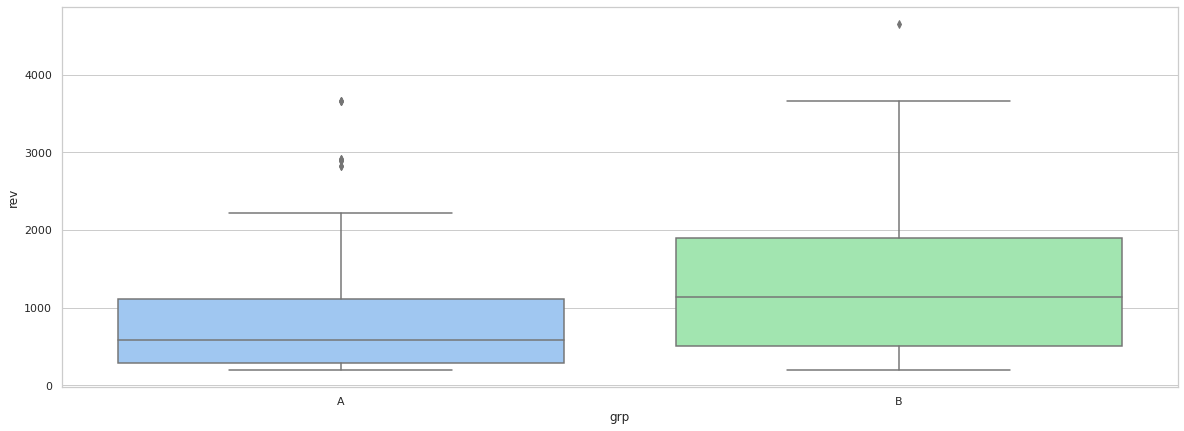

In [367]:
sns.boxplot(x='grp', y='rev', data = users_active.query('rev_flag == 1'))

Распределения ненормальные, выбросы есть, дисперсии гомоскедастичны

Обратимся к бутстрепу

In [368]:
arppu = users_active[users_active.rev_flag == 1][['grp', 'rev']]

In [369]:
arppu_b = arppu.query('grp == "B"')
arppu_a = arppu.query('grp == "A"')

In [370]:
stats.bootstrap((arppu_a.rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=750.6199135511637, high=1166.183816889714), standard_error=103.25786821969453)

In [371]:
stats.bootstrap((arppu_b.rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1172.1755135854971, high=1345.6128122049506), standard_error=44.80885283790711)

In [372]:
mean_diff_arppu = []

for i in range(10000):
    sample_data_control = arppu_a.sample(frac=1, replace=True)
    sample_mean_control = sample_data_control.rev.mean()
    
    
    sample_data_exp = arppu_b.sample(frac=1, replace=True)
    sample_data_exp = sample_data_exp.rev.mean()
    
    sample_mean_diff_arppu = sample_data_exp - sample_mean_control
    mean_diff_arppu.append(sample_mean_diff_arppu)

In [373]:
pd.Series(mean_diff_arppu).quantile(0.975)

536.070351272252

In [374]:
pd.Series(mean_diff_arppu).quantile(0.025)

98.87516799832625

In [375]:
0 не входит в доверительный интервал, можем отклонить Н0 - ARPPU в группах статистически значимо не различается

SyntaxError: invalid syntax (<ipython-input-375-9d301932af23>, line 1)

Построим график, чтобы увидеть как выглядит распределение разницы средних
По результатам bootstrap теста разница среднего (доверительный интервал) находится в диапазоне от 94 до 538, не включает ноль, а это значит разница средних является стат значимой, поэтому мы можем отклонить Н0 - ARPPU в группах статистически значимо не различается

In [ ]:
data_arppu  = pd.DataFrame(mean_diff_arppu)

In [ ]:
quantiles_1 = data_arppu.quantile([l, r])

In [ ]:
_, _, bars = plt.hist(data_arppu[0], bins=50)
for bar in bars:
        if bar.get_x() <= quantiles_1.iloc[0][0] or bar.get_x() >= quantiles_1.iloc[1][0]:
            bar.set_facecolor('rosybrown')
        else: 
            bar.set_facecolor('darkseagreen')
            bar.set_edgecolor('black')
    
plt.style.use('seaborn-pastel')
plt.vlines(quantiles_1, ymin=0, ymax=100, linestyle='--')
plt.xlabel('data')
plt.ylabel('difference')
plt.title("Mean diff ARPPU")
plt.show()

**Вывод:**
Рассчитав метрики было видно, что для тестовой группы конверсия в покупку упала, однако выросли обе метрики связанные с выручкой на пользователя (средняя выручка на совершившего покупку пользователя, средняя выручка на активного пользователя).

Чтобы убедиться в стат значимости были провелены статистические тесты:
гипотеза о наличии различий была принята только при проверке ARPPU, что показал bootstrap, в случае с конверсией и ARPU мы наоборот приняли нулевую гипотезу. 

Новую механику оплаты можно запустить, поскольку ARPU и ARPPU растут, CR, возможно, упал из-за того, что дизайн сайта не до конца настроен, например, проблемы в UX-дизайне.

Однако, еще стоит обратить внимание на то, что размеры групп были не совсем равнозначны, на результаты теста bootstrap этот критерий особо не влияет, но, кажется, что есть необходимость в уточнении того, как формировались выборки для проведения эксперимента, после уточнения итог можно интерпретировать с полной уверенностью.

# Задание 2. SQL

**2.1 Очень усердные ученики.**

**2.1.1 Условие**

   - Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

   - Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

**2.1.2 Задача**

Дана таблица default.peas

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [ ]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Посмотрим, как выглядит наша таблица, дату напротив id каждого студента приведём к первому числу месяца, чтобы понимать в каком месяце было сделано задание

In [ ]:
query1 = '''
SELECT
    st_id,
    correct,
    subject,
    toStartOfMonth(timest) AS month_of_work
FROM default.peas
'''

In [ ]:
SQL = ph.read_clickhouse(query = query1, 
                               connection = connection_default)
SQL.head(5)

Посмотрим, за какой промежуток времени у нас есть данные, чтобы в дальнейшем считать количество задач для id каждого студента только за текущий период

In [ ]:
query2 = '''
SELECT DISTINCT month_of_work
FROM (
SELECT
    st_id,
    SUM(correct) AS number,
    toStartOfMonth(timest) AS month_of_work
FROM default.peas
GROUP BY st_id, month_of_work
)
'''

In [ ]:
SQL_2 = ph.read_clickhouse(query = query2, 
                               connection = connection_default)
SQL_2

Как видно, у нас данные только за октябрь, поэтому теперь можем сразу посчитать ответ

In [ ]:
query3 = '''
SELECT
    COUNT(st_id) AS students
FROM(
SELECT
    st_id,
    SUM(correct) AS number,
    toStartOfMonth(timest) AS month_of_work
FROM default.peas
GROUP BY st_id, month_of_work
HAVING number >= 20
)
'''

In [ ]:
SQL_3 = ph.read_clickhouse(query = query3, 
                               connection = connection_default)
SQL_3

In [ ]:
print(f"В текущем месяце {SQL_3['students'][0]} усердных студентов")

**2.2 Оптимизация воронки**

**2.2.1 Условие**

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

**2.2.2 Задача**

Даны таблицы: default.peas, default.studs и default.final_project_check. 

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

 - ARPU 
 - ARPAU 
 - CR в покупку 
 - СR активного пользователя в покупку 
 - CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
 
 

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [ ]:
query4 = '''
SELECT test_grp, 
    SUM(user_money)/COUNT(st_id) AS ARPU,
    SUMIf(user_money, number > 10) / COUNTIf(st_id, number>10) AS ARPAU,
    COUNTIf(user_money, user_money>0) / COUNT(st_id) * 100 AS CR,
    COUNT(CASE WHEN number > 10 and user_money > 0 then st_id END) / COUNTIf(st_id, number>10) * 100 AS CR_active_user,
    COUNT(CASE WHEN number_of_math >= 2 and math_money > 0 then st_id END) / COUNT(CASE WHEN number_of_math >= 2 then st_id END) * 100 AS CR_math_active_user

FROM (
SELECT *
FROM default.studs AS l1
LEFT JOIN (
SELECT st_id,
    SUM(correct) AS number,
    SUMIf(correct, subject='Math') AS number_of_math
FROM default.peas
GROUP BY st_id
) AS r1 
USING(st_id)
) AS l2 



LEFT JOIN (
    SELECT st_id,
        SUM(money) AS user_money,
        SUMIf(money, subject='Math') AS math_money
    FROM default.final_project_check
    GROUP BY st_id
    ) AS r2
USING(st_id)
GROUP BY test_grp
'''

In [ ]:
SQL_4 = ph.read_clickhouse(query = query4, 
                               connection = connection_default)
SQL_4

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
sns.barplot(data=SQL_4, x='test_grp', y='ARPU', ax=axes[0]).set(title='CR', xlabel = 'group', ylabel='')
sns.barplot(data=SQL_4, x='test_grp', y='ARPAU', ax=axes[1]).set(title='ARPU', xlabel = 'group', ylabel='')
sns.barplot(data=SQL_4, x='test_grp', y='CR', ax=axes[2]).set(title='ARPPU', xlabel = 'group', ylabel='')
sns.barplot(data=SQL_4, x='test_grp', y='CR_active_user', ax=axes[3]).set(title='ARPPU', xlabel = 'group', ylabel='')
sns.barplot(data=SQL_4, x='test_grp', y='CR_math_active_user', ax=axes[4]).set(title='ARPPU', xlabel = 'group', ylabel='')
plt.show

# Задание 3. Python

**3.1 Задача**

 - Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
 - Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [376]:
api_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
api_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
api_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
group_nw = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

In [377]:
new_data = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

In [378]:
def add_data(link1, link2, link3, new_data):
    
    """
    Функция, которая автоматически подгружает информацию из 
    дополнительного файла и на основании дополнительных параметров пересчитывает метрики.
    """
    
    def yandex_data(public_key, sep=';'):
        """
        Функция считывает csv-файлы с Яндекс-диска с помощью API, а затем загружает их в блокнот
        """
        response = req.get(f'https://cloud-api.yandex.net/v1/disk/public/resources?public_key={public_key}').json()
        file = response['file']
        dataframe = pd.read_csv(file, sep=sep)
        return dataframe
    
    groups = yandex_data(link1, ';')
    active_studs = yandex_data(link2, ';')
    checks = yandex_data(link3, ';')
    groups_add = yandex_data(new_data, ',')
    
    
    df_final = pd.concat([groups, groups_add], ignore_index=True)
    active_studs = active_studs.rename(columns={'student_id': 'id'})
    checks = checks.rename(columns={'student_id': 'id'})
   

    active_studs['activity'] = 1

    df_final_users = df_final.merge(active_studs, how='outer', on='id')
    df_final_users_checks = df_final_users.merge(checks, how='outer', on='id')
    df_final_users_checks = df_final_users_checks.fillna(0)

    
    df_final_users_checks.loc[df_final_users_checks['rev']>0, 'rev_flag'] = 1
    df = df_final_users_checks.query('activity == 1')
    df = df.fillna(0)
    
    
    final = df.groupby('grp', as_index=False).agg({'id': 'count', 'rev': 'sum', 'rev_flag': 'sum'}) \
        .rename(columns = {'rev' : 'revenue', 'rev_flag' : 'users_with_payment', 'id': 'users'})
    final['CR'] = (final.users_with_payment/final.users).mul(100)
    final['ARPU'] = (final.revenue/final.users)
    final['ARPPU'] = (final.revenue/final.users_with_payment)
    return final.drop(['users', 'revenue', 'users_with_payment'], axis=1)

In [379]:
dt = add_data(api_groups, api_active_studs, api_checks, new_data)
dt

,grp,CR,ARPU,ARPPU
0,A,5.071521,47.347204,933.589744
1,B,4.615611,58.058798,1257.878992


In [380]:
def vizualisation(data):
    """
    Функция, которая будет строить графики по получаемым метрикам.
    """
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
    
    sns.barplot(data=dt, x='grp', y='CR', ax=axes[0]).set(title='CR', xlabel = 'group', ylabel='')
    sns.barplot(data=dt, x='grp', y='ARPU', ax=axes[1]).set(title='ARPU', xlabel = 'group', ylabel='')
    sns.barplot(data=dt, x='grp', y='ARPPU', ax=axes[2]).set(title='ARPPU', xlabel = 'group', ylabel='')
    plt.show

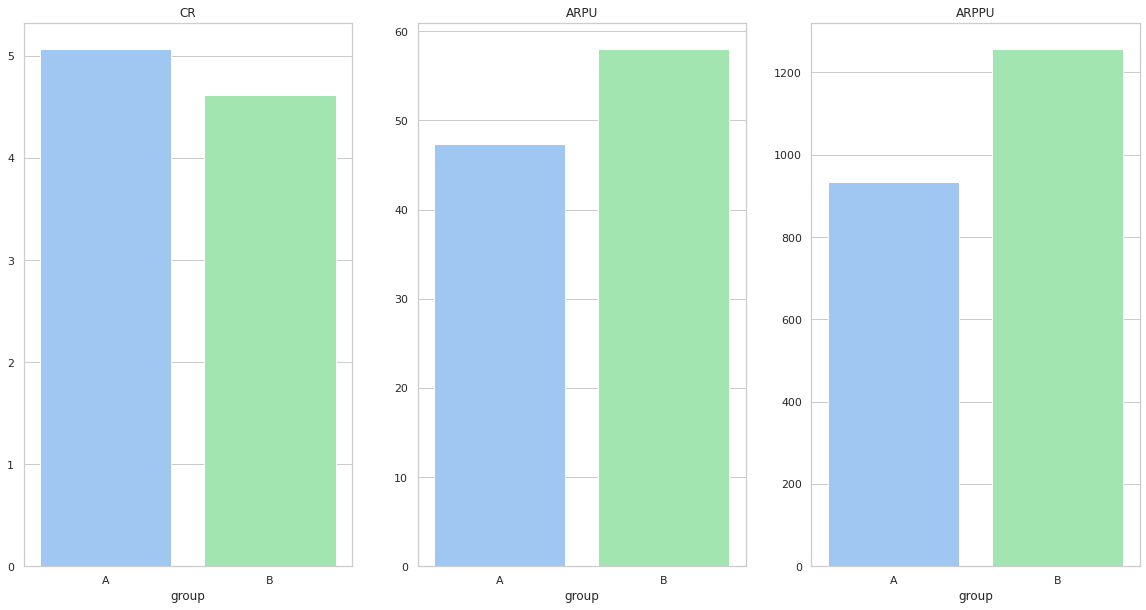

In [381]:
vizualisation(dt)